In [10]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from rlearning.lib.envs.multi_gridworld import MutliGridworldEnv
from rlearning.lib import plotting

matplotlib.style.use('ggplot')

In [11]:
env = MutliGridworldEnv()

In [12]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [13]:
def sarsa(env, num_episodes, REWARD_WEIGHT, DECAY = 1, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
   
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        REWARD_WEIGHT[0] = REWARD_WEIGHT[0] * 0.99
        REWARD_WEIGHT[1] = 1 - REWARD_WEIGHT[0]
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)

            reward = np.array(reward).dot(REWARD_WEIGHT)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done or t > 10000:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [14]:
def stat(stats):
    DEATHS = np.sum(np.array(stats.episode_lengths) > 100)
    print ('Deaths:', DEATHS)
    AVGS = np.convolve(stats.episode_lengths, np.ones((50,))/50, mode='valid')
    print ('Average Episode:', AVGS)
    REW = np.convolve(stats.episode_rewards, np.ones((50,))/50, mode='valid')
    print ('Average Reward:', REW)

In [15]:
import seaborn as sns
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

In [16]:
def plot_stats(stats_list, smoothing_window=20, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    smoothed = []
    labels = np.array(['R', 'F', '0.9R + 0.1F (λ=0.99)', '0.9R + 0.1F (λ=0.999)', '0.9R + 0.1F'])
    hour, direction = np.meshgrid(np.arange(len(stats_list[0].episode_lengths)), labels)
    df = pd.DataFrame({"hour": hour.flatten(), "direction": direction.flatten()})

    for stats in stats_list:
        episodes_smoothed = pd.Series(stats.episode_lengths).rolling(smoothing_window, 
                                                                     min_periods=smoothing_window).mean().as_matrix()
        smoothed = smoothed + episodes_smoothed.tolist()
    print (len(smoothed))
    print (len(df))
    df["episode_length"] = smoothed

    plt.figure(figsize=(12,8))
    g = sns.tsplot(df, time='hour', unit = "direction", condition='direction', value='episode_length')
    g.set(ylim=(0, 400))

Episode 500/500.

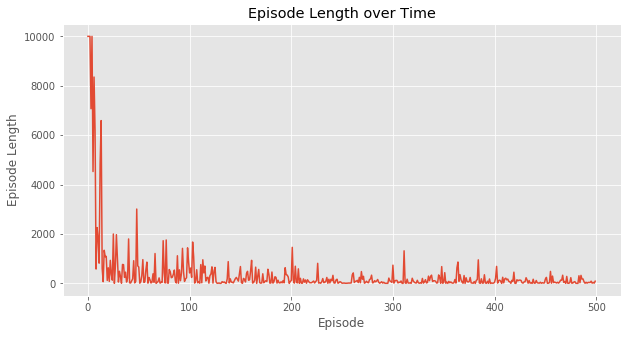

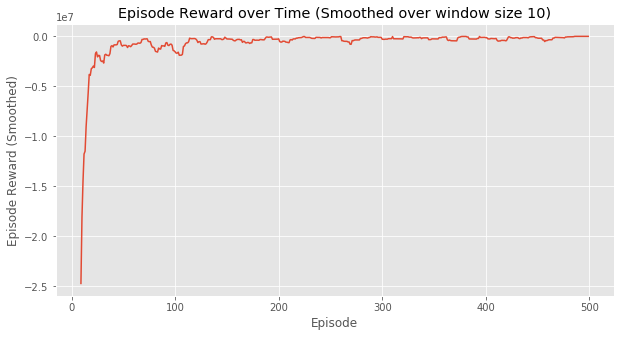

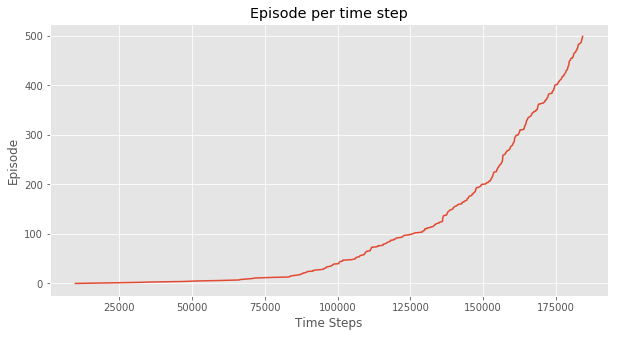

In [17]:
Q, stats = sarsa(env, 500, np.array([0, 1]))
plotting.plot_episode_stats(stats)
stats1 = stats

Episode 500/500.

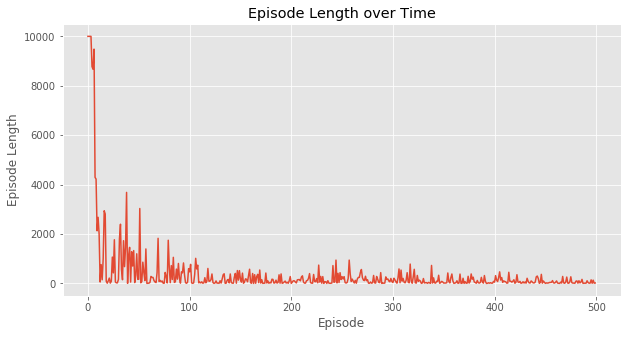

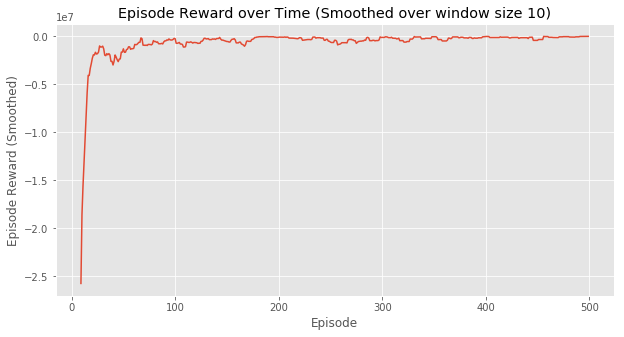

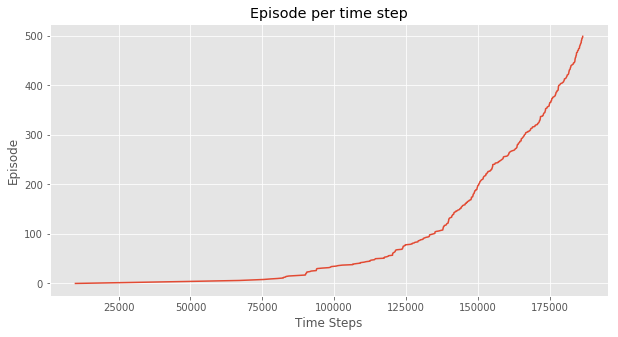

In [18]:
Q, stats = sarsa(env, 500, np.array([1, 0]))
plotting.plot_episode_stats(stats)
stats2 = stats

Episode 500/500.

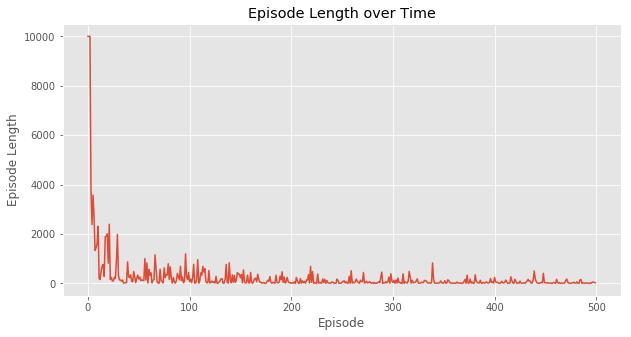

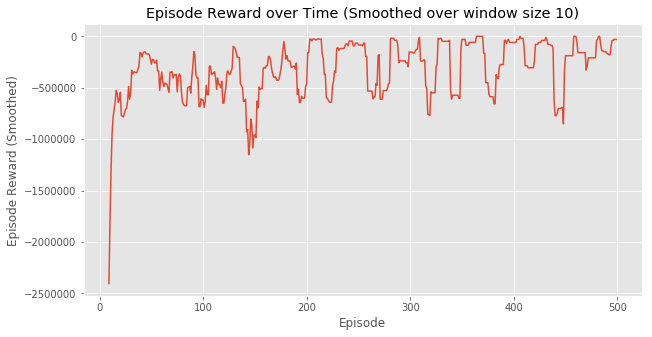

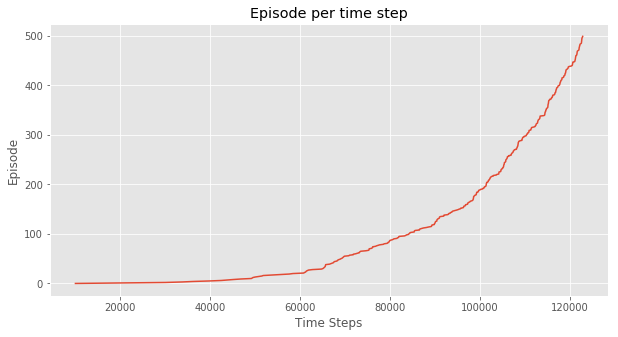

In [19]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]), 0.99)
plotting.plot_episode_stats(stats)
stats3 = stats

Episode 500/500.

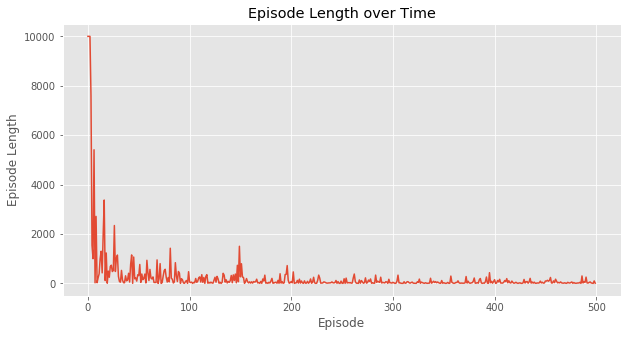

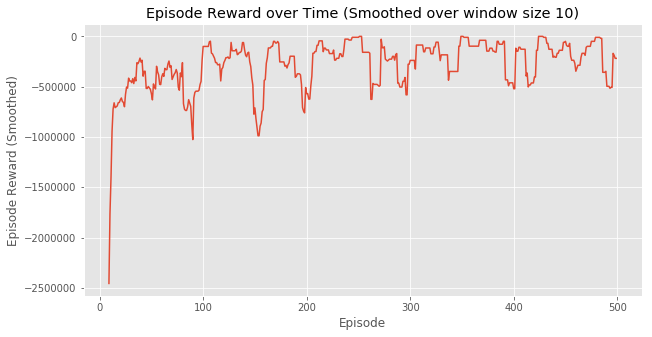

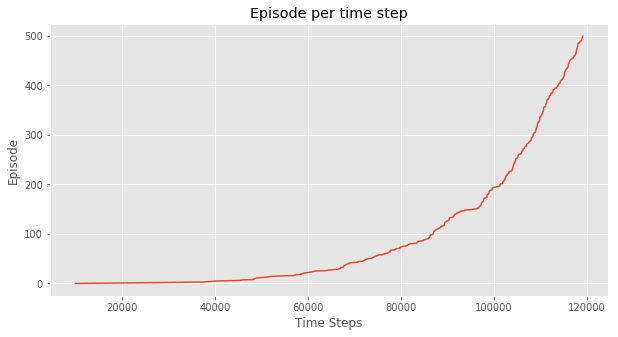

In [20]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]), 0.999)
plotting.plot_episode_stats(stats)
stats4 = stats

Episode 500/500.

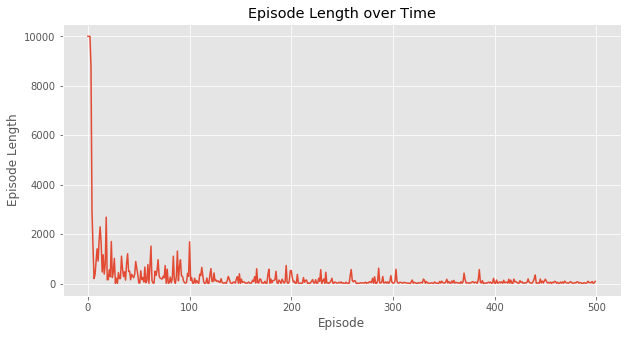

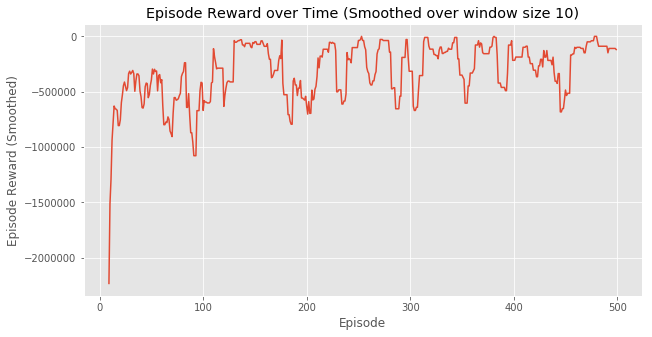

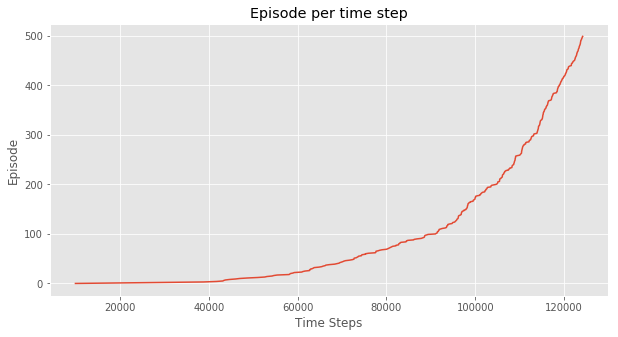

In [21]:
Q, stats = sarsa(env, 500, np.array([0.9, 0.1]))
plotting.plot_episode_stats(stats)
stats5 = stats

NameError: name 'stats1' is not defined

2500
2500


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


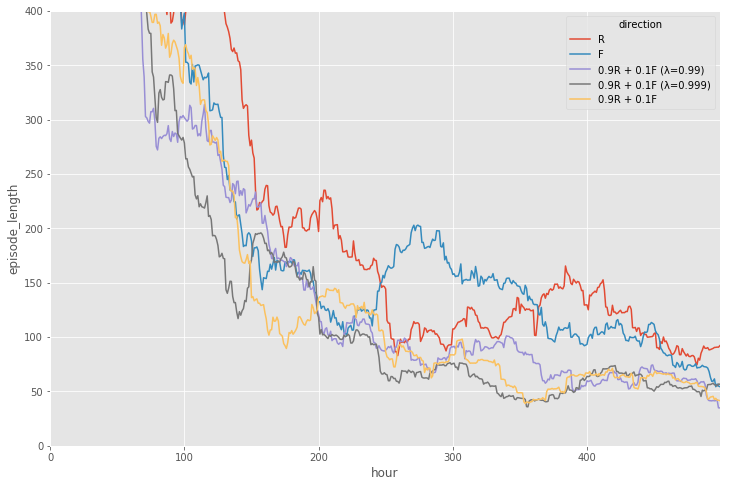

In [22]:
stats_list = [stats1, stats2, stats3, stats4, stats5]
plot_stats(stats_list, 50)